In [134]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt

In [135]:
prod_data = pd.read_csv('production_data.csv')
wells_data =  pd.read_csv('wellsData.csv')
op_aliasing_data = pd.read_csv('operator_aliasing.csv')

C:\Users\Nourhan Khaled\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (21,26) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [136]:
# Dropping duplicates from prod_data 
prod_data = prod_data.drop_duplicates(subset=['API', 'Month', 'Year'], keep='last', inplace=False)

In [137]:
# dropping unnecessary columns from tables
cols = ['API', 'Year', 'Month', 'Liquid', 'Gas', 'RatioGasOil']
prod_data = prod_data[cols]

cols = ['API', 'SpudDate', 'CompletionDate', 'operatorNameIHS', 'BasinName']
wells_data = wells_data[cols]

cols = ['Name', 'Alias']
op_aliasing_data = op_aliasing_data[cols]

In [138]:
# adding zeros to API
wells_data['API'] = (wells_data['API']).astype(str)
wells_data['API'] = wells_data['API'].apply(lambda x: x.zfill(14))

In [139]:
# adding zeros to API
prod_data['API'] = (prod_data['API']).astype(str)
prod_data['API'] = prod_data['API'].apply(lambda x: x.zfill(14))

In [140]:
# renaming operators
alias_dict = dict(zip(op_aliasing_data.Name, op_aliasing_data.Alias))
wells_data['operatorNameIHS'] = wells_data['operatorNameIHS'].map(alias_dict).fillna(wells_data['operatorNameIHS'])

In [141]:
# storing peak records 
idx_max = prod_data.groupby(['API'])['Liquid'].transform('max') == prod_data['Liquid']
max_month_prod_data = prod_data[idx_max].drop_duplicates(subset='API', keep='first', inplace=False)
list_indices = ['API', 'Year', 'Month', 'Liquid']
max_month_prod_data = max_month_prod_data[list_indices]
max_month_prod_data = max_month_prod_data.rename(columns={"Year": "Max_Year", "Month": "Max_Month", "Liquid": "Max_Liquid"})

In [142]:
# merging the two dataframes to get max month and max year
new_prod_data_orig = prod_data.merge(max_month_prod_data, on='API')

In [143]:
# Remove Pre-Peak Months (clean up)
new_prod_data = new_prod_data_orig[((new_prod_data_orig['Year'] == new_prod_data_orig['Max_Year']))]
new_prod_data = new_prod_data[(new_prod_data['Month'] >= new_prod_data['Max_Month'])]

new_prod_data2 = new_prod_data_orig[((new_prod_data_orig['Year'] > new_prod_data_orig['Max_Year']))]
new_prod_data3 = new_prod_data.append(new_prod_data2)

In [144]:
# calculates month index
def calc_month_index(max_year, max_month, year, month):
    return (12 - max_month + (year - max_year - 1)*12 + month) * (year != max_year) + (year == max_year) * (month - max_month) + 1 

In [145]:
# adding month index column to post peak production data
new_prod_data3['index'] = calc_month_index(new_prod_data3['Max_Year'], new_prod_data3['Max_Month'], new_prod_data3['Year'], new_prod_data3['Month'])
indexed_prod_data = new_prod_data3

## Problems encountered

- 0 max liquid production, fixed by setting first month as peek month

- missing months data in indexing months, fixed by super smart indexing equation

- missing month data in plotting, will be fixed by moving average inshaAllah

- CompletionDate removed Nulls and replaced them with Non-null Spuddates + six months

- removed duplicate entries for API, Month, Year by keeping the last updated one

- removed null spuddates and null completion dates from wells_data

- Missing APIs in wells_data, but existing in prod data and vice versa?

In [146]:
# removed nullified SpudDates and CompletionDates
wells_data = wells_data[~((wells_data['SpudDate'].isnull()) & (wells_data['CompletionDate'].isnull()))]

In [147]:
# replacing null CompletionDates with SpudDates + six months
wells_data['SpudDate'] = pd.to_datetime(wells_data['SpudDate'])
wells_data['CompletionDate'] = pd.to_datetime(wells_data['CompletionDate'])
wells_data.loc[wells_data['CompletionDate'].isnull(), 'CompletionDate'] = wells_data['SpudDate'] + timedelta(days=170) 

In [148]:
# Dropping SpudDate column
cols = ['API', 'CompletionDate', 'operatorNameIHS', 'BasinName']
wells_data = wells_data[cols]

In [149]:
# table for holding 4 basins of interest
wells_data_4basins = wells_data[wells_data['BasinName'] == 'DENVER BASIN']
wells_data_4basins = wells_data_4basins.append(wells_data[wells_data['BasinName'] == 'PERMIAN BASIN'])
wells_data_4basins = wells_data_4basins.append(wells_data[wells_data['BasinName'] == 'ANADARKO BASIN'])
wells_data_4basins = wells_data_4basins.append(wells_data[wells_data['BasinName'] == 'WILLISTON BASIN'])
wells_data_4basins['API'] = wells_data_4basins['API'].astype(str)

In [150]:
# merging wells with indexed production data
indexed_wells_4basins = wells_data_4basins.merge(indexed_prod_data, on='API')

In [151]:
# returns statistics for first plot
def get_stats(basin, index, table):
    group = table[(table['BasinName'] == basin) & (table['index'] == index)]
    group_liquid = group["Liquid"]
    mean = group_liquid.mean()
    median = group_liquid.median()
    perct = group_liquid.quantile(.9)
    liquid = group_liquid
    return [[mean], [median], [perct], liquid]

In [154]:
# 2014 split
pre2014 = indexed_wells_4basins[indexed_wells_4basins['CompletionDate'] < '2014-01-01']
post2014 = indexed_wells_4basins[indexed_wells_4basins['CompletionDate'] >= '2014-01-01']
indices = np.arange(36) + 1
basins = ["ANADARKO BASIN","DENVER BASIN", "PERMIAN BASIN", "WILLISTON BASIN"]

# calculating stats
all_stats_pre = np.array([[get_stats(y, x, pre2014) for x in indices] for y in basins]) 
all_stats_post = np.array([[get_stats(y, x, post2014) for x in indices] for y in basins]) 

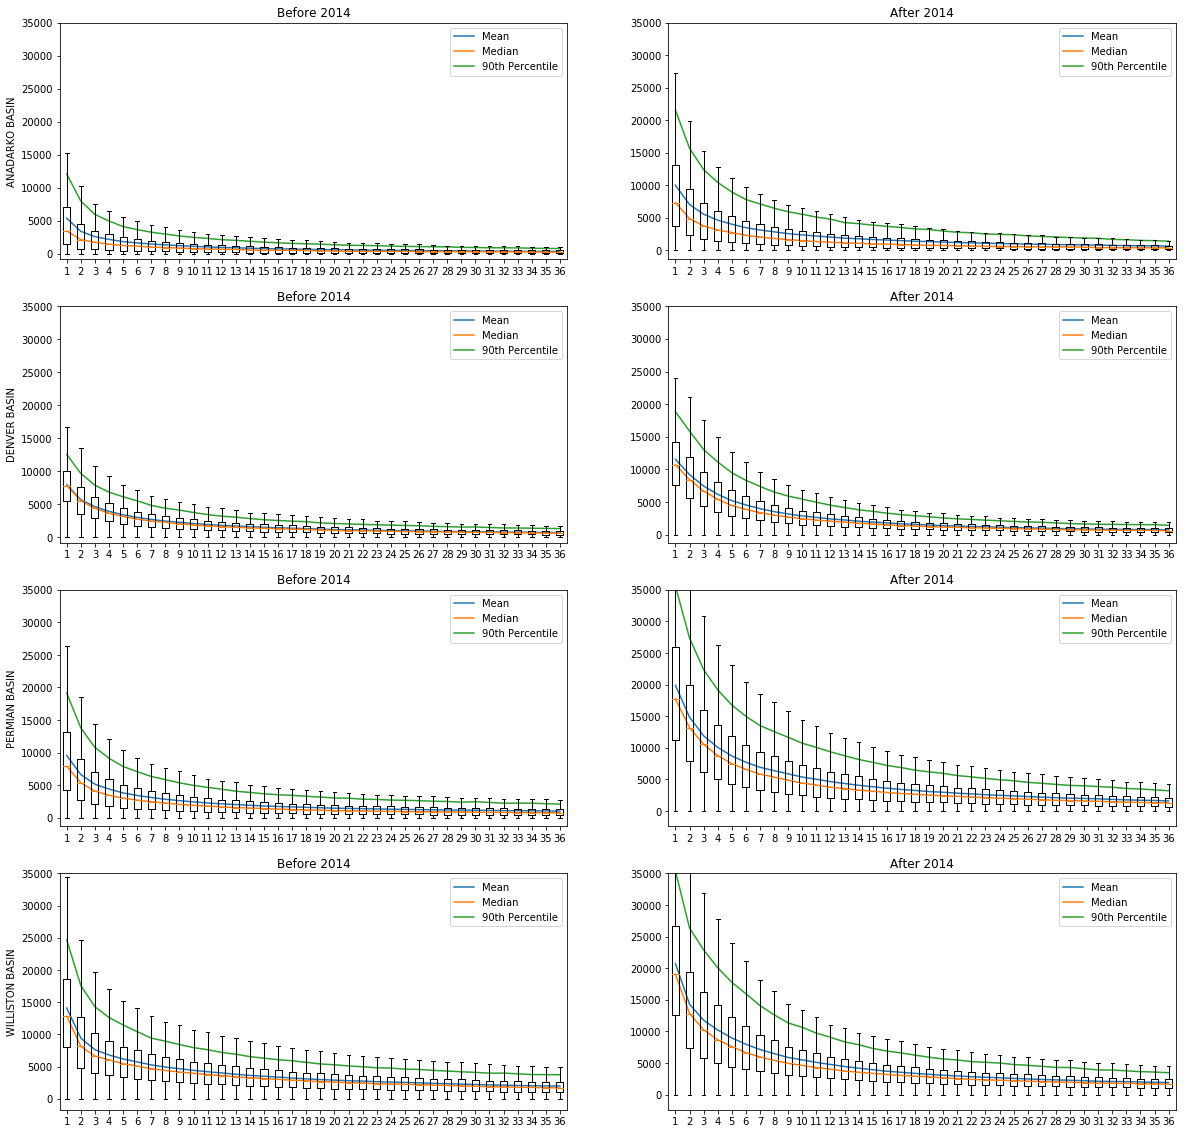

In [155]:
plt.rcParams["figure.figsize"]=20,20
plt.rcParams["font.size"] = 10

idx = 1
for i in range(len(basins)):

    ax1 = plt.subplot(4,2,idx)
    ax1.plot(indices, np.hstack(all_stats_pre[i,:,0]), label="Mean")
    ax1.plot(indices, np.hstack(all_stats_pre[i,:,1]), label="Median")
    ax1.plot(indices, np.hstack(all_stats_pre[i,:,2]), label="90th Percentile")
    ax1.boxplot(list(all_stats_pre[i,:,3]), showfliers=False)
    ax1.set_ylim(top=35000)
    ax1.legend()
    ax1.set_title('Before 2014')
    ax1.set_ylabel(basins[i])
    idx += 1

    ax2 = plt.subplot(4,2,idx)
    ax2.plot(indices, np.hstack(all_stats_post[i,:,0]), label="Mean")
    ax2.plot(indices, np.hstack(all_stats_post[i,:,1]), label="Median")
    ax2.plot(indices, np.hstack(all_stats_post[i,:,2]), label="90th Percentile")
    ax2.boxplot(list(all_stats_post[i,:,3]), showfliers=False)
    ax2.set_ylim(top=35000)
    ax2.set_title('After 2014')
    ax2.legend()
    
    idx += 1
    
plt.savefig('part1.png')



## Observations and Insights:
- All basins follow the same pattern of liquid production decreasing logarithmically as the wells grow older. 
- Rate tends to stabilize roughly after the 18th month.
- Difference in barrels can be noted before 2014 and after 2014, new drilling tech yields more promising results
- Permian and Williston, largest productions, (many potential outliers) a number of large values shown by boxplot maximum going over 90th percentile, but not being considered outliers by still appearing in the box plot.
- In all basins, there are wells that produce zero oil, shown by the minimum of the box plot, this might indicate the existence of gas in the corresponding wells.
- Difference between mean and median suggests the existence of outliers. Since the mean is above the median, then the outliers are in the high end of the distribution. This is noticeable in the early months where the production is high, and most prominent in the Anadarko basin. Across basins, the Denver basin has the least difference between the mean and median, with the pre-2014 values being almost the same. 

In [156]:
# #remove months larger than 60 old method
five_years_data = indexed_wells_4basins
five_years_data['max_index_five_years'] = five_years_data['index'].groupby(five_years_data['API']).transform("max")
five_years_data = five_years_data[five_years_data['max_index_five_years'] >= 60]
five_years_data = five_years_data[five_years_data['index'] <= 60]

Method 2 for calculating 5 years data

In [157]:
# # removing wells from after Feb 2014 [METHOD 2]
# five_years_data = indexed_wells_4basins[(indexed_wells_4basins['Max_Year'] < 2014) |((indexed_wells_4basins['Max_Year'] == 2014) & (indexed_wells_4basins['Max_Month'] == 1))] 
# five_years_data = five_years_data[five_years_data['index'] <= 60] #I don't think we should do this

In [158]:
# returns production for given basin over 5 years as percentages
def cumm_prod_basin_year(basin, table): 
    total = table[(table['BasinName'] == basin)]
    total_liquid = total["Liquid"].sum()
    percents = np.zeros(5)
    for year in range(5):
        lower = (year)*12
        upper = (year + 1)*12
        group = total[(total['index'] > lower) & (total['index'] <= upper)]['Liquid']
        group_liquid = group.sum()
        percents[year] = ((group_liquid*100)/total_liquid)                
        
    return percents
    

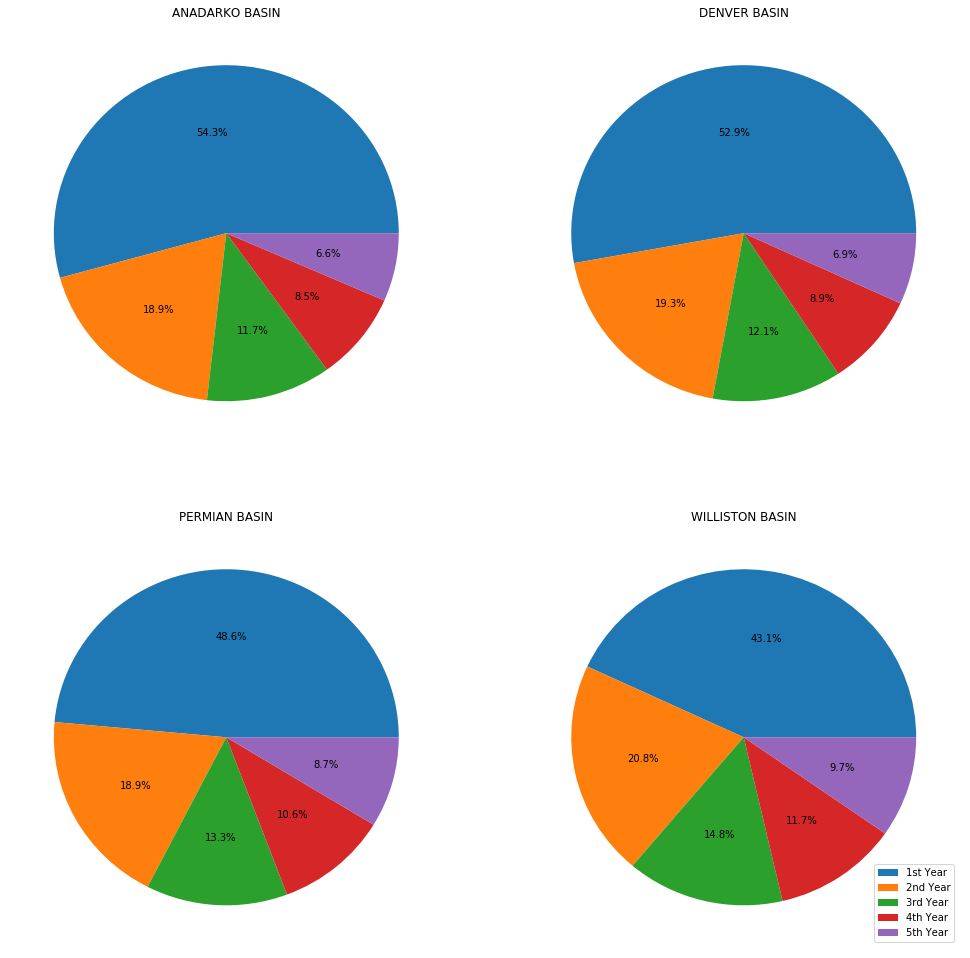

In [159]:
percentages = [cumm_prod_basin_year(y, five_years_data) for y in basins ]

plt.rcParams["figure.figsize"]=17,17
labels = ['1st Year', '2nd Year', '3rd Year', '4th Year', '5th Year']

for i in range(len(basins)):

    ax1 = plt.subplot(2,2,i+1)
    ax1.pie(percentages[i], autopct='%1.1f%%', shadow=False)
    ax1.set_title(basins[i])

plt.legend(labels, loc=4)
plt.savefig('Plot2.png')

## Observations and Insights:
- Obviously, the first 12 months post peak have the highest production  producing roughly 50% of the basin’s production over 5 years, declining.
- The highest producing basins (Williston and Permian) have the least production percentages in their first years unlike Denver and Anadarko. Could be good for the business to know so as not to consider the first year as an indication of expected production.
- Across all basins, the difference between production in the last two years is approximately 2%.


In [26]:
# returns 5 years cumulative oil and gas production for a given basin
def cumm_prod_wells(table, basin):
    total = table[(table['BasinName'] == basin)]
    liq = total.groupby(total['API'])['Liquid'].sum()
    gas = total.groupby(total['API'])['Gas'].sum()
    return liq, gas

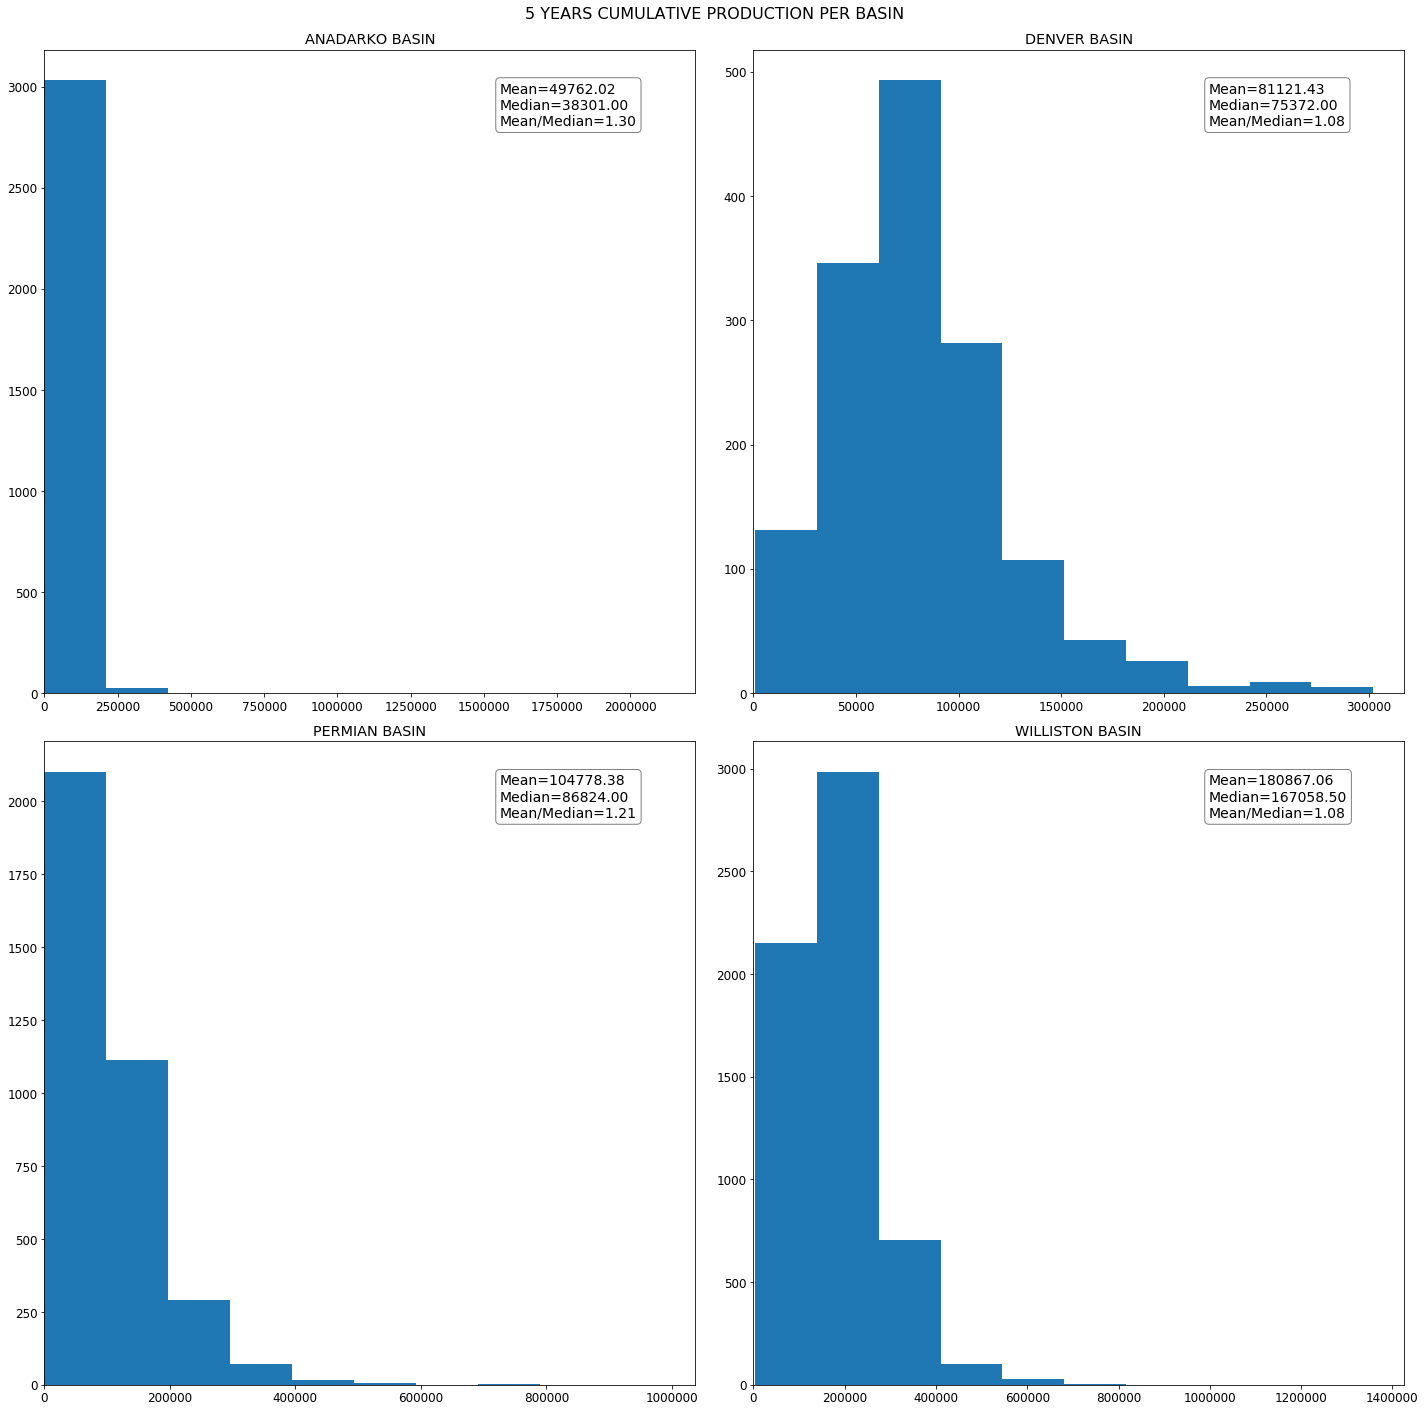

In [160]:

plt.rcParams.update({'font.size': 12})
plt.rcParams["figure.figsize"] = 20,20

vals = np.array([cumm_prod_wells(five_years_data, y) for y in basins])

liq = vals[:, 0]
gas = vals[:, 1]
fig=plt.figure()

for i in range(len(basins)):
    ax1 = plt.subplot(2,2,i+1)
    ax1.hist(liq[i])
    ax1.set_title(basins[i])
    ax1.set_xlim(left=0)
    ax1.set_xlabel
    mean = liq[i].mean()
    median = liq[i].median()
    mean_med = mean/median
    
    textstr = 'Mean=' + str('%.2f'%mean) + '\n'+'Median=' + str('%.2f'%median)+ '\n'+'Mean/Median='+ str('%.2f'%mean_med)
    props = dict(boxstyle='round',facecolor='white', alpha=0.5)
    ax1.text(0.7, 0.95, textstr, transform=ax1.transAxes, fontsize=14, verticalalignment='top', bbox=props)

fig.suptitle('5 YEARS CUMULATIVE PRODUCTION PER BASIN', fontsize=16) 
fig.tight_layout()
fig.subplots_adjust(top=0.95)

plt.savefig('Plot3.png')

## Observations and Insights:
- All histograms exhibit the behaviour of a right skewed normal distribution with varying standard deviations. This would allow us to use logarithms later in calculations.
- The majority of wells in the Anadarko and Permian basins (better way to say) having small values could mean that there are mostly gas wells in these basins.
- In the Anadarko basin, well liquid production is smaller than other basins, with the majority of wells producing in the 0 - 200000 range, and some up to 600000, and with a very few of what may be outliers producing in the 2000000 range. The outlier theory is also confirmed with there being a large difference between the mean and median, and having the highest mean/median ratio. As mentioned before, this is probably because there are mostly gas wells in this basin.
- The Denver basin exhibits the least right skewedness. While well production is over a smaller range of values, the wells are distributed more evenly among it.  The basin has the smallest mean/median ratio. 
- Similar to Anadarko, the Permian basin seems to also have a lot of gas wells, however it has more liquid producing wells than Anadarko, having a much larger mean of 104778. It also has some outliers producing large amounts of liquid production in the 800000 range.
- The Williston histogram has the largest mean production of the four wells, yet also has the smallest mean/median ratio which implies few outliers. 
## INSIGHT TO BE REVISED PLEASEEE  @ MARIEEMMMM 
- Difference in 2 techniques to calculate cumulative production shown to have notable difference in Anadarko basin: This might be due to wells dying out early. Because we only look on things that  produce for at least 5 years regardless of completion date while the other method considers any well that has completion date at least 5 years ago regardless of whether it is still producing or not i.e., has month indices >= 60. The other method shows more values for anadarko on the histogram because it doesn't disregard those wells.


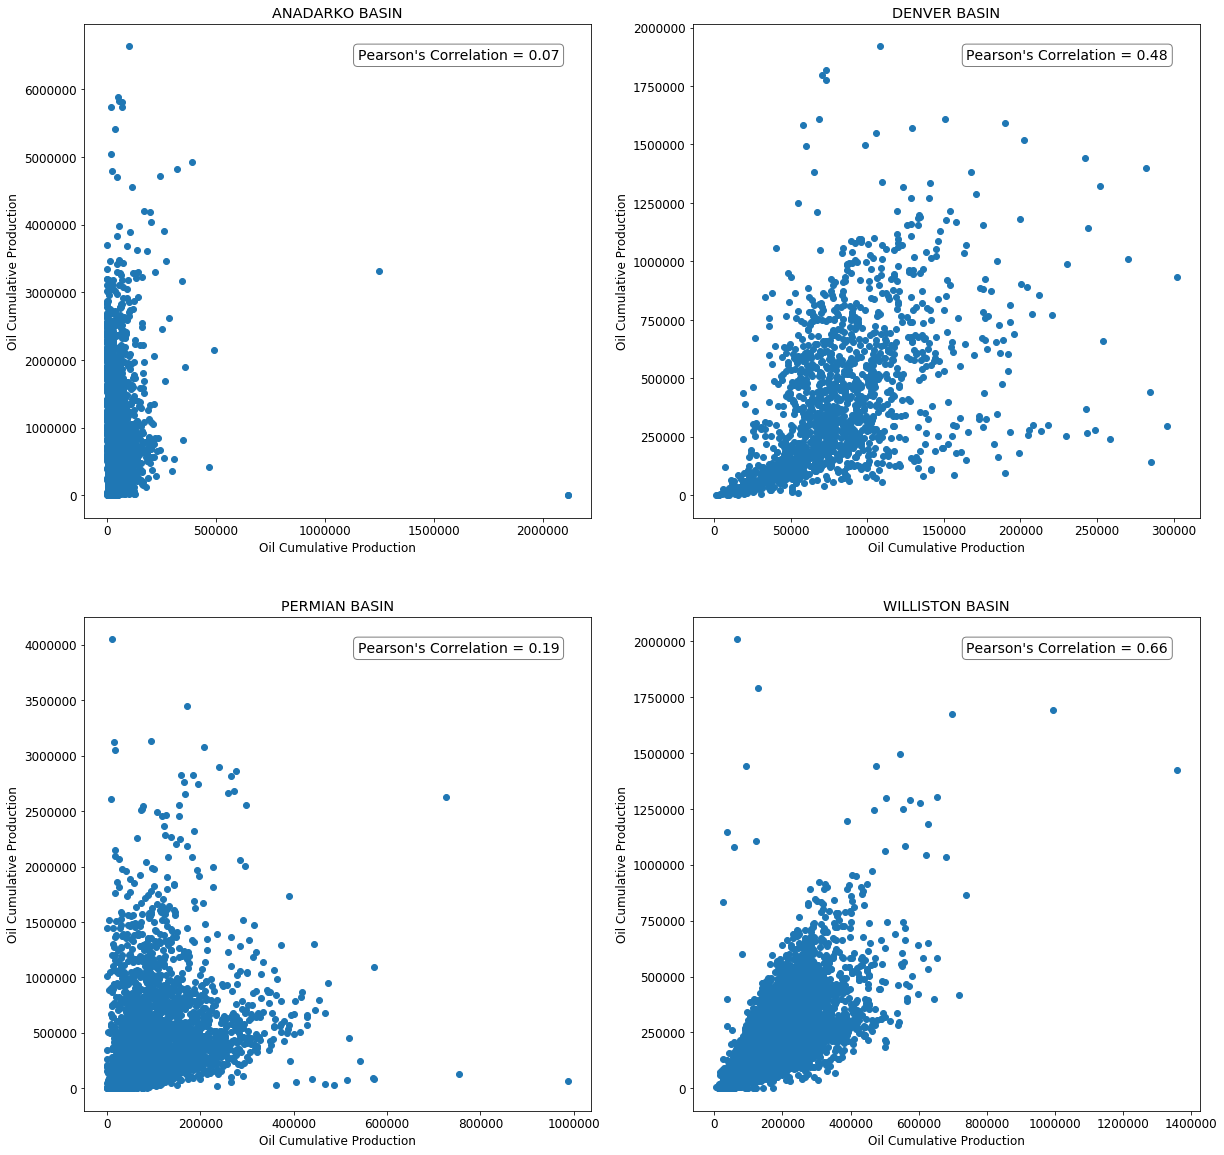

In [161]:
plt.rcParams["figure.figsize"] = 20,20

for i in range(len(basins)):
    ax1 = plt.subplot(2,2,i+1)
    ax1.scatter(liq[i], gas[i])
    ax1.set_title(basins[i])
    p_corr = gas[i].corr(liq[i], method='pearson')
    textstr = 'Pearson\'s Correlation = '+ str('%.2f'% p_corr)
    props = dict(boxstyle='round',facecolor='white', alpha=0.5)
    ax1.text(0.54, 0.95, textstr, transform=ax1.transAxes, fontsize=14, verticalalignment='top', bbox=props)
    ax1.set_xlabel('Oil Cumulative Production')
    ax1.set_ylabel('Oil Cumulative Production')

    
plt.savefig('Plot4.png')

## Observations and Insights:
- Some wells among those who have minimal oil production have high gas production, shown by the vertical scatter around the zero mark. These are prominent in Anadarko, Permian and Williston. Anadarko produces relatively more gas than the other basins. 
- Anadarko is the most notable to have exclusive gas wells.
- Williston has the highest Pearson correlation, shown by the linear compacted/low variance scatter of points. This indicates that a well that has high oil production is likely to have a proportional gas production. This would be useful for an operator to know.


In [162]:
wells_all_basins = wells_data.merge(indexed_prod_data, on='API')
sum_all_basins = wells_all_basins
sum_all_basins['TotalLiquid'] = wells_all_basins.groupby(['BasinName'])['Liquid'].transform('sum')
sum_all_basins =sum_all_basins.drop_duplicates(subset=['API'], keep='first', inplace=False)

In [163]:
def find_count_wells(basinName, table):
    return len(table[table['BasinName'] == basinName].drop_duplicates(subset=['API'], keep='first', inplace=False))

In [164]:
### Fifth plot, showing percentage of wells that last for at least five years out of all of the wells
## owned, also comparing the total volume of liquid
def getLiquid(table, basin):
    arr = (np.array(table[table['BasinName'] ==  basin]['TotalLiquid']))
    return arr[0]

count_all_wells_4basins = np.array([find_count_wells(y, indexed_wells_4basins) for y in basins])
count_five_years_wells_4basins = np.array([find_count_wells(y, five_years_data) for y in basins])

z_values = np.hstack([getLiquid(sum_all_basins, y) for y in basins])

y = count_all_wells_4basins
z = count_five_years_wells_4basins/count_all_wells_4basins
z

array([0.33689075, 0.2086756 , 0.19258507, 0.45471152])

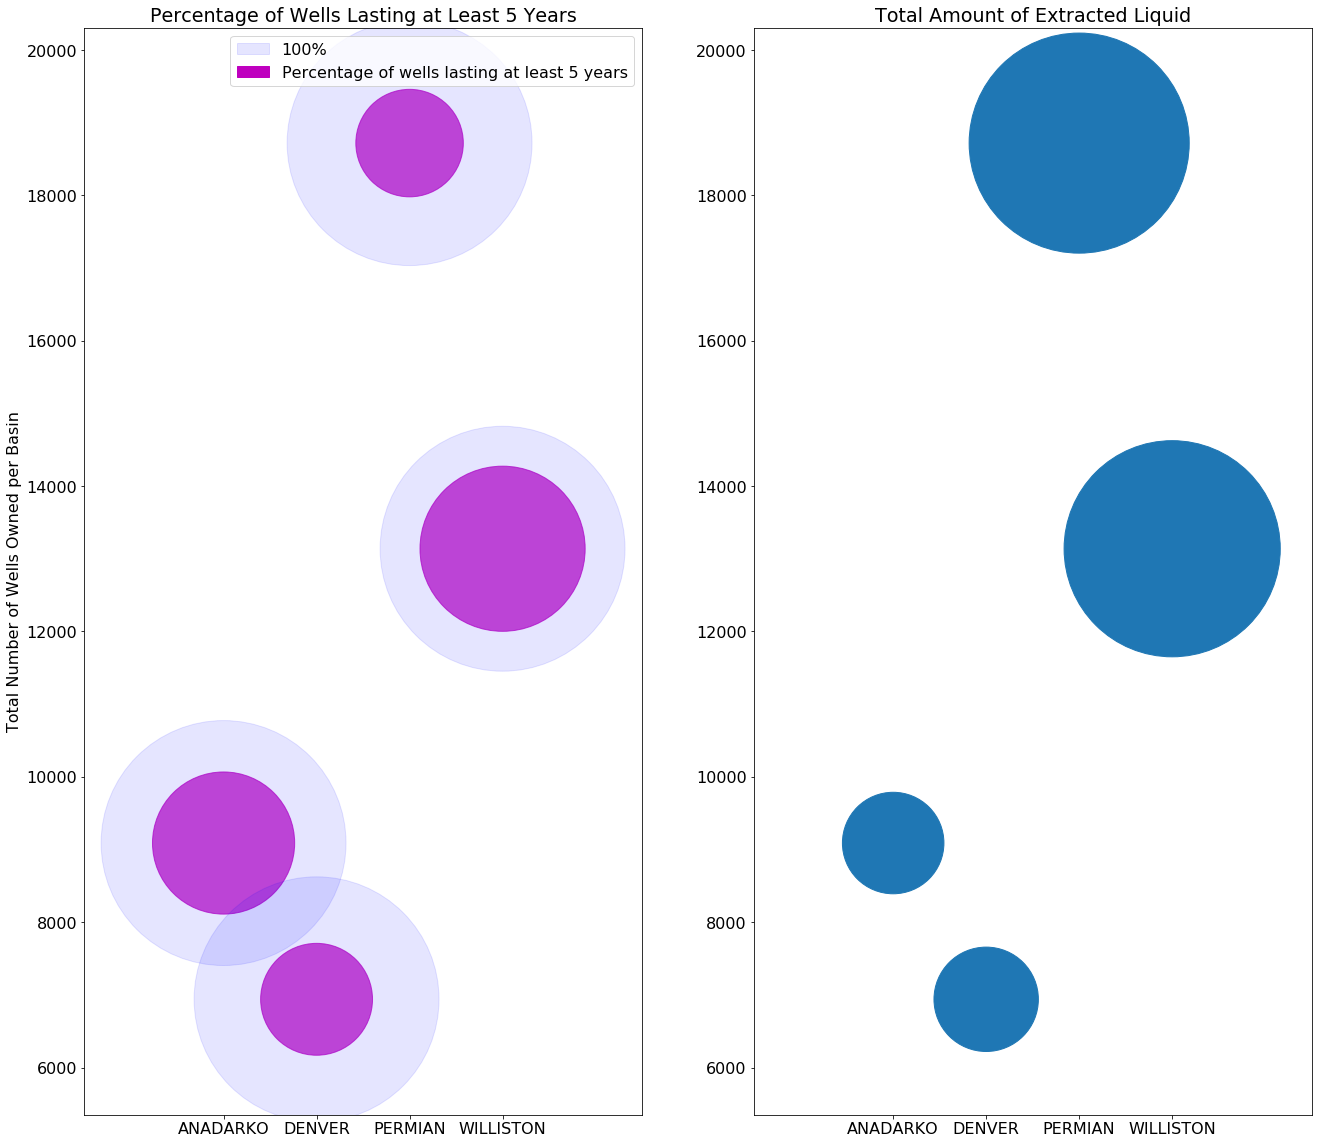

In [174]:
import matplotlib.patches as mpatches

basin_names = [x[:-6] for x in basins]
plt.rcParams["figure.figsize"] = 22,20
plt.rcParams.update({'font.size': 16})
x_axis = np.arange(len(basins))

# subplot 1
ax1 = plt.subplot(1,2,1)
size_scaler = 60000
ax1.scatter(x_axis, y, s=z*size_scaler, alpha =0.7, color='m')
ax1.scatter(x_axis, y, s=np.ones(4)*size_scaler, color='b', alpha=0.1)

ax1.xaxis.set_ticks(x_axis)
ax1.xaxis.set_ticklabels(basin_names, rotation=0)
ax1.set_title('Percentage of Wells Lasting at Least 5 Years')

red_patch = mpatches.Patch(color='b', label='100%', alpha=0.1)
blue_patch = mpatches.Patch(color='m', label='Percentage of wells lasting at least 5 years', alpha=1)
ax1.legend(handles=[red_patch, blue_patch], loc='best')


# subplot 2 
ax2 = plt.subplot(1,2,2)
ax2.scatter(np.arange(len(basins)), y, s=z_values*0.00002, alpha =1)
ax2.xaxis.set_ticks(np.arange(len(basins)))
ax2.xaxis.set_ticklabels(basin_names, rotation=0)
ax2.set_title('Total Amount of Extracted Liquid')

ax1.set_ylabel('Total Number of Wells Owned per Basin')
ax1.set_xlim(-1.5, 4.5)
ax1.set_ylim(y1-1000, y2 + 1000)

ax2.set_xlim(-1.5, 4.5)
ax2.set_ylim(y1-1000, y2 + 1000)
plt.savefig('Plot5.png')
plt.show()

- In this plot, we aimed at providing two sets of visual comparisons between the 4 basins that we have been focusing on in the previous plots. 
- In the first subplot, we present the percentage of the wells that last at least five years out of all of the wells that each of the 4 major basins own. The idea was that on the y-value would denotes the total number of wells, while the size of the bubble chart would denote the percentage; hence the bigger the percentage, the bigger the size of the bubble. 
- In the second subplot, we wanted to provide some sort of comparison between the amount of liquid extracted alongside the number of wells owned by each basin. Therefore, in this plot the size of bubble depends on the quantity of extracted liquid. -The bigger the bubble, the bigger the quantity of that liquid.
-Obviously, one can not draw clear conclusions from this tiny subset of the dataset, however some things are worth pointing out:
    -Basins tend to extract similar quantities of liquid if they have similar amount of wells.
    -Clearly, the larger number of wells owned by a well, the bigger the quantity of extracted liquid.
    -There is no direct correlation (at least according to this subset of basins) between the number of wells owned by a basin and the percentage of those wells lasting at least five years.
